In [1]:
import os
import sys

# Add the parent directory of the current script and 'src' folder to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.model_unet import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your saved data
test_data = torch.load("../data/prepared_datasets/train_flowers.pt")
test_labels = torch.load("../data/prepared_datasets/train_flowers_labels.pt")
val_data = torch.load("../data/prepared_datasets/val_flowers.pt")
val_labels = torch.load("../data/prepared_datasets/val_flowers_labels.pt")
train_data = torch.load("../data/prepared_datasets/test_flowers.pt")
train_labels = torch.load("../data/prepared_datasets/test_flowers_labels.pt")

In [3]:
train_data.shape

torch.Size([6149, 3, 64, 64])

In [4]:
batch_size = 32

In [5]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [6]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [10]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [11]:
timesteps = 200
betas = DiffusionSchedule.linear_beta_schedule(timesteps).clone()
diffusion_params = DiffusionSchedule.compute_diffusion_parameters(betas)

In [12]:
from torchvision.utils import save_image

epochs = 40
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber", diffusion_params=diffusion_params)
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()
            
          

Epoch 1/40:   1%|          | 1/193 [00:00<01:34,  2.04it/s]

Loss: 0.46161460876464844


Epoch 1/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.53it/s]

Loss: 0.12978073954582214



Epoch 2/40:   1%|          | 2/193 [00:00<00:20,  9.10it/s]]

Loss: 0.04944595694541931


Epoch 2/40:  53%|█████▎    | 102/193 [00:10<00:10,  9.08it/s]

Loss: 0.046439409255981445



Epoch 3/40:   1%|          | 2/193 [00:00<00:19,  9.65it/s]]

Loss: 0.051518797874450684


Epoch 3/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.49it/s]

Loss: 0.0561179593205452



Epoch 4/40:   1%|          | 2/193 [00:00<00:21,  8.78it/s]]

Loss: 0.05488063022494316


Epoch 4/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.14it/s]

Loss: 0.027779532596468925



Epoch 5/40:   1%|          | 2/193 [00:00<00:19,  9.82it/s]]

Loss: 0.03456726297736168


Epoch 5/40:  53%|█████▎    | 102/193 [00:10<00:10,  8.59it/s]

Loss: 0.045246582478284836



Epoch 6/40:   1%|          | 2/193 [00:00<00:20,  9.21it/s]]

Loss: 0.04380076378583908


Epoch 6/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.72it/s]

Loss: 0.03573867678642273



Epoch 7/40:   1%|          | 2/193 [00:00<00:20,  9.39it/s]]

Loss: 0.03015384078025818


Epoch 7/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.45it/s]

Loss: 0.03828611224889755



Epoch 8/40:   1%|          | 2/193 [00:00<00:19,  9.69it/s]]

Loss: 0.05874671787023544


Epoch 8/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.91it/s]

Loss: 0.036751747131347656



Epoch 9/40:   1%|          | 2/193 [00:00<00:20,  9.39it/s]]

Loss: 0.03934173658490181


Epoch 9/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.81it/s]

Loss: 0.025317883118987083



Epoch 10/40:   1%|          | 2/193 [00:00<00:22,  8.58it/s]

Loss: 0.03610369563102722


Epoch 10/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.79it/s]

Loss: 0.03537280857563019



Epoch 11/40:   1%|          | 2/193 [00:00<00:19,  9.85it/s]]

Loss: 0.03441967815160751


Epoch 11/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.74it/s]

Loss: 0.03499207645654678



Epoch 12/40:   1%|          | 2/193 [00:00<00:20,  9.33it/s]]

Loss: 0.030684281140565872


Epoch 12/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.60it/s]

Loss: 0.022968223318457603



Epoch 13/40:   1%|          | 2/193 [00:00<00:23,  8.16it/s]]

Loss: 0.02971106767654419


Epoch 13/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.41it/s]

Loss: 0.03858618065714836



Epoch 14/40:   1%|          | 2/193 [00:00<00:21,  9.04it/s]]

Loss: 0.024629857391119003


Epoch 14/40:  53%|█████▎    | 102/193 [00:11<00:10,  9.00it/s]

Loss: 0.06835915148258209



Epoch 15/40:   1%|          | 2/193 [00:00<00:19,  9.91it/s]]

Loss: 0.03890053927898407


Epoch 15/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.90it/s]

Loss: 0.026791399344801903



Epoch 16/40:   1%|          | 2/193 [00:00<00:20,  9.29it/s]]

Loss: 0.029067151248455048


Epoch 16/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.27it/s]

Loss: 0.027825351804494858



Epoch 17/40:   1%|          | 2/193 [00:00<00:20,  9.52it/s]]

Loss: 0.03379419445991516


Epoch 17/40:  53%|█████▎    | 102/193 [00:11<00:10,  9.05it/s]

Loss: 0.0364668034017086



Epoch 18/40:   1%|          | 2/193 [00:00<00:20,  9.31it/s]]

Loss: 0.038613125681877136


Epoch 18/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.69it/s]

Loss: 0.022258585318922997



Epoch 19/40:   1%|          | 1/193 [00:00<00:24,  7.87it/s]]

Loss: 0.03634791076183319


Epoch 19/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.56it/s]

Loss: 0.028471684083342552



Epoch 20/40:   1%|          | 2/193 [00:00<00:18, 10.31it/s]]

Loss: 0.03669936954975128


Epoch 20/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.20it/s]

Loss: 0.03692290931940079



Epoch 21/40:   1%|          | 2/193 [00:00<00:21,  9.00it/s]]

Loss: 0.04535695165395737


Epoch 21/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.83it/s]

Loss: 0.044001951813697815



Epoch 22/40:   1%|          | 2/193 [00:00<00:22,  8.60it/s]]

Loss: 0.027108144015073776


Epoch 22/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.57it/s]

Loss: 0.033880457282066345



Epoch 23/40:   1%|          | 2/193 [00:00<00:21,  8.88it/s]]

Loss: 0.023366805166006088


Epoch 23/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.88it/s]

Loss: 0.03792707249522209



Epoch 24/40:   1%|          | 2/193 [00:00<00:22,  8.52it/s]]

Loss: 0.048276133835315704


Epoch 24/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.29it/s]

Loss: 0.02138330414891243



Epoch 25/40:   1%|          | 2/193 [00:00<00:21,  8.70it/s]]

Loss: 0.031418390572071075


Epoch 25/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.25it/s]

Loss: 0.029996618628501892



Epoch 26/40:   1%|          | 2/193 [00:00<00:21,  8.89it/s]]

Loss: 0.04202970117330551


Epoch 26/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.28it/s]

Loss: 0.04761575907468796



Epoch 27/40:   1%|          | 2/193 [00:00<00:21,  8.81it/s]]

Loss: 0.034487493336200714


Epoch 27/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.58it/s]

Loss: 0.02426353096961975



Epoch 28/40:   1%|          | 2/193 [00:00<00:20,  9.31it/s]]

Loss: 0.03088897094130516


Epoch 28/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.18it/s]

Loss: 0.032407213002443314



Epoch 29/40:   1%|          | 2/193 [00:00<00:20,  9.50it/s]]

Loss: 0.021937301382422447


Epoch 29/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.16it/s]

Loss: 0.02660665288567543



Epoch 30/40:   1%|          | 2/193 [00:00<00:19,  9.56it/s]]

Loss: 0.029106182977557182


Epoch 30/40:  53%|█████▎    | 102/193 [00:11<00:10,  8.86it/s]

Loss: 0.03842715173959732



Epoch 31/40:   1%|          | 2/193 [00:00<00:21,  8.87it/s]]

Loss: 0.038688044995069504


Epoch 31/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.38it/s]

Loss: 0.024935804307460785



Epoch 32/40:   1%|          | 2/193 [00:00<00:20,  9.32it/s]]

Loss: 0.0438816100358963


Epoch 32/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.43it/s]

Loss: 0.039952877908945084



Epoch 33/40:   1%|          | 2/193 [00:00<00:20,  9.23it/s]]

Loss: 0.033509835600852966


Epoch 33/40:  52%|█████▏    | 101/193 [00:10<00:09,  9.50it/s]

Loss: 0.030792564153671265



Epoch 34/40:   1%|          | 2/193 [00:00<00:20,  9.27it/s]]

Loss: 0.04132407158613205


Epoch 34/40:  52%|█████▏    | 101/193 [00:10<00:09,  9.44it/s]

Loss: 0.02994433417916298



Epoch 35/40:   1%|          | 2/193 [00:00<00:20,  9.23it/s]]

Loss: 0.05079657956957817


Epoch 35/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.40it/s]

Loss: 0.03501604497432709



Epoch 36/40:   1%|          | 2/193 [00:00<00:19,  9.63it/s]]

Loss: 0.03379402309656143


Epoch 36/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.54it/s]

Loss: 0.023957138881087303



Epoch 37/40:   1%|          | 2/193 [00:00<00:19,  9.76it/s]]

Loss: 0.0239163339138031


Epoch 37/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.90it/s]

Loss: 0.03169357776641846



Epoch 38/40:   1%|          | 2/193 [00:00<00:22,  8.32it/s]]

Loss: 0.03913051262497902


Epoch 38/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.33it/s]

Loss: 0.045517902821302414



Epoch 39/40:   1%|          | 2/193 [00:00<00:18, 10.19it/s]]

Loss: 0.04745866358280182


Epoch 39/40:  53%|█████▎    | 102/193 [00:10<00:09,  9.24it/s]

Loss: 0.025013666599988937



Epoch 40/40:   1%|          | 2/193 [00:00<00:19,  9.72it/s]]

Loss: 0.03386745601892471


Epoch 40/40:  53%|█████▎    | 102/193 [00:11<00:09,  9.40it/s]

Loss: 0.025433335453271866



poch 40/40: 100%|██████████| 193/193 [00:20<00:00,  9.36it/s]

In [13]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
}, 'model_resnet_flowers.pth')

In [14]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)
checkpoint = torch.load('model_resnet_flowers.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [15]:
print(image_size,channels)
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels, diffusion_params=diffusion_params)

64 3



ampling loop time step: 100%|██████████| 200/200 [00:07<00:00, 27.92it/s]

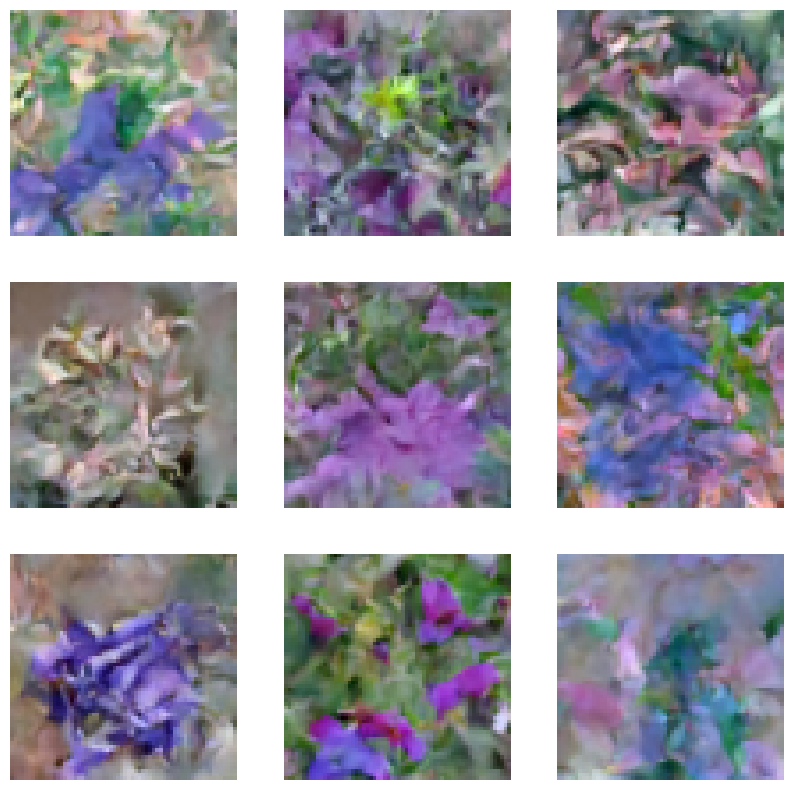

In [16]:
import numpy as np
num_images = 9

plt.figure(figsize=(10, 10)) 

for i in range(num_images):
    img = samples[-1][i] 
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) 
    img = (img - img.min()) / (img.max() - img.min()) 

    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
    plt.imshow(img)
    plt.axis('off')  # Hide axis

    # Save the individual image with a unique name
    #plt.imsave(f"saved_image{i+1}.png", img)

#plt.tight_layout()
plt.show()

In [18]:
timesteps

200